In [2]:
!pip install numpy pandas scikit-learn matplotlib seaborn

# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# For warnings (to keep our output clean)
import warnings
warnings.filterwarnings("ignore")

print("Dependencies loaded successfully.")


Dependencies loaded successfully.


In [4]:
# Define the file paths including the 'archive_2' folder
train_file_path = "archive_2/KDDTrain+.txt"
test_file_path = "archive_2/KDDTest+.txt"

# Define column names for the dataset
column_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
    "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate",
    "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
    "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
    "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate",
    "label", "difficulty"
]

# Load the training data
try:
    train_df = pd.read_csv(train_file_path, header=None, names=column_names)
    print("Training data loaded successfully. Shape:", train_df.shape)
except Exception as e:
    print("Error loading training data:", e)

# Load the test data
try:
    test_df = pd.read_csv(test_file_path, header=None, names=column_names)
    print("Test data loaded successfully. Shape:", test_df.shape)
except Exception as e:
    print("Error loading test data:", e)


Training data loaded successfully. Shape: (125973, 43)
Test data loaded successfully. Shape: (22544, 43)


In [6]:
# Copy the datasets to avoid modifying the original data
train_data = train_df.copy()
test_data = test_df.copy()

# Drop the 'difficulty' column since we won't use it for classification
train_data.drop('difficulty', axis=1, inplace=True)
test_data.drop('difficulty', axis=1, inplace=True)

# Separate features and labels. The label column is 'label'
X_train = train_data.drop('label', axis=1)
y_train = train_data['label']

X_test = test_data.drop('label', axis=1)
y_test = test_data['label']

# List of categorical features that need to be converted
categorical_features = ['protocol_type', 'service', 'flag']

# One-hot encode the categorical features for both training and testing data.
X_train_encoded = pd.get_dummies(X_train, columns=categorical_features)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_features)

# Align the test set's columns with the training set columns (fill missing ones with zeros)
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

print("Preprocessing complete. Training features shape:", X_train_encoded.shape)


Preprocessing complete. Training features shape: (125973, 122)


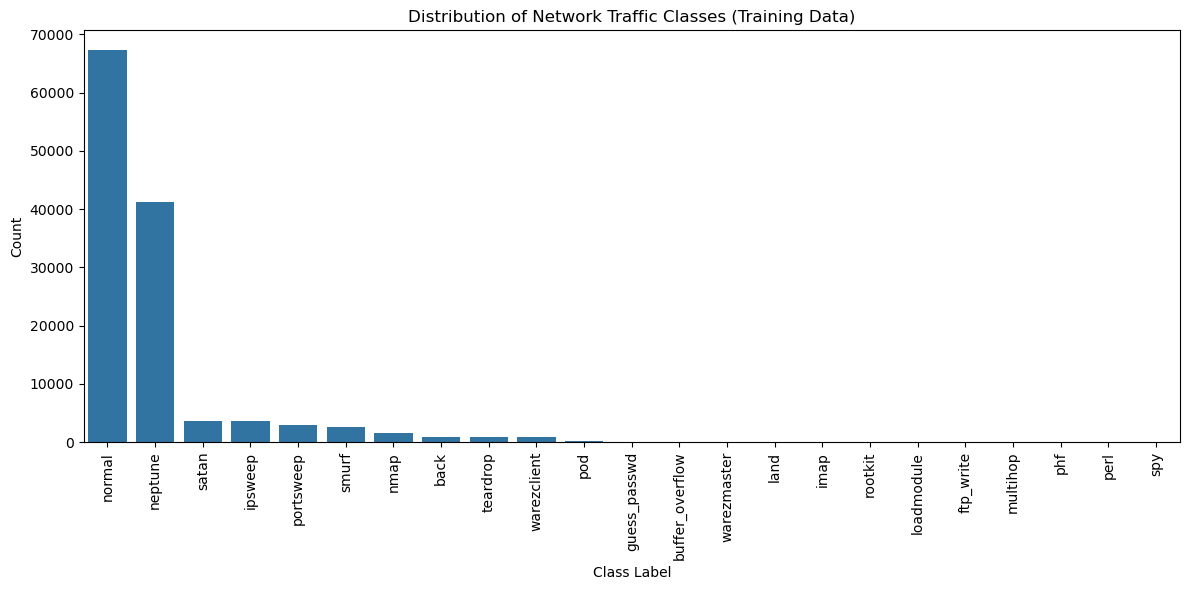

In [8]:
# Plot the distribution of classes in the training data
plt.figure(figsize=(12, 6))
sns.countplot(data=train_df, x='label', order=train_df['label'].value_counts().index)
plt.xticks(rotation=90)
plt.title("Distribution of Network Traffic Classes (Training Data)")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [10]:
# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
rf_classifier.fit(X_train_encoded, y_train)

print("Model training complete.")


Model training complete.


Confusion Matrix:
[[  0  72   0 ...   0   0   0]
 [  0 350   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   1 ...   0   0   0]]

Classification Report:
                 precision    recall  f1-score   support

        apache2       0.00      0.00      0.00       737
           back       0.83      0.97      0.90       359
buffer_overflow       0.00      0.00      0.00        20
      ftp_write       0.00      0.00      0.00         3
   guess_passwd       0.00      0.00      0.00      1231
     httptunnel       0.00      0.00      0.00       133
           imap       0.00      0.00      0.00         1
        ipsweep       0.73      0.98      0.83       141
           land       1.00      0.43      0.60         7
     loadmodule       0.00      0.00      0.00         2
       mailbomb       0.00      0.00      0.00       293
          mscan       0.00      0.00      0.00       996
       multihop       0.

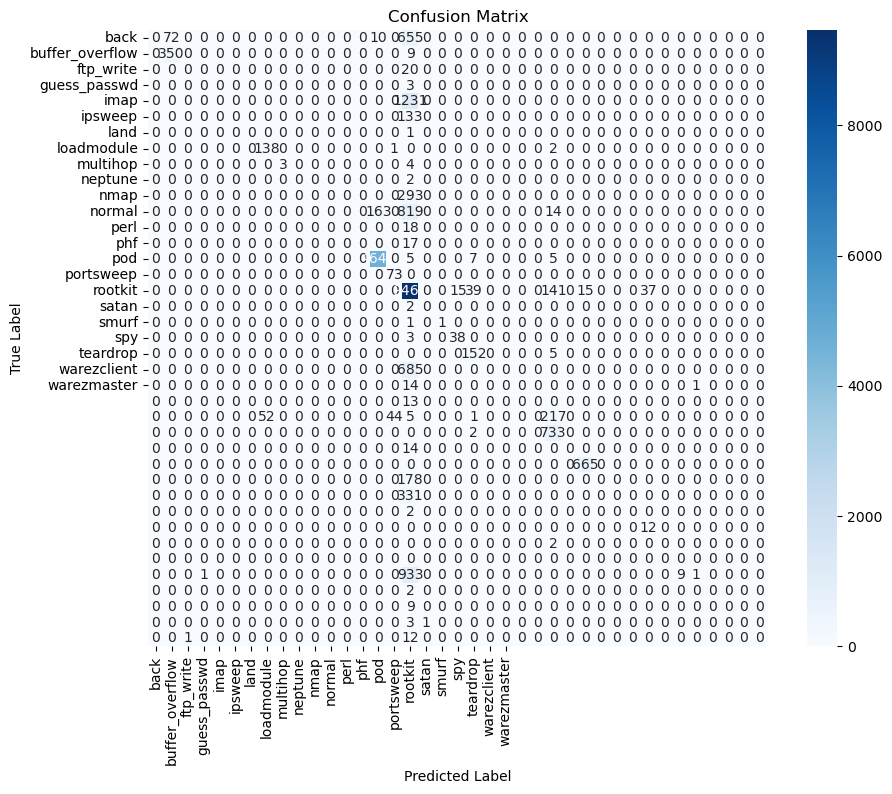

In [12]:
# Predict on the test data
y_pred = rf_classifier.predict(X_test_encoded)

# Compute the confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=rf_classifier.classes_, yticklabels=rf_classifier.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [14]:
# Create a new DataFrame that includes predictions and original labels for comparison
results_df = X_test.copy()
results_df['True_Label'] = y_test.values
results_df['Predicted_Label'] = y_pred

# Filter out the records predicted as attacks (i.e., not "normal")
anomalies = results_df[results_df['Predicted_Label'] != 'normal']

print("Number of potential anomalies detected:", anomalies.shape[0])
print("Some example anomalies:")
print(anomalies.head())


Number of potential anomalies detected: 7663
Some example anomalies:
    duration protocol_type  service flag  src_bytes  dst_bytes  land  \
0          0           tcp  private  REJ          0          0     0   
1          0           tcp  private  REJ          0          0     0   
3          0          icmp    eco_i   SF         20          0     0   
12         0           tcp  private  REJ          0          0     0   
13         0           tcp   telnet   S0          0          0     0   

    wrong_fragment  urgent  hot  ...  dst_host_same_srv_rate  \
0                0       0    0  ...                    0.04   
1                0       0    0  ...                    0.00   
3                0       0    0  ...                    1.00   
12               0       0    0  ...                    0.01   
13               0       0    0  ...                    0.73   

    dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
0                     0.06                          0.

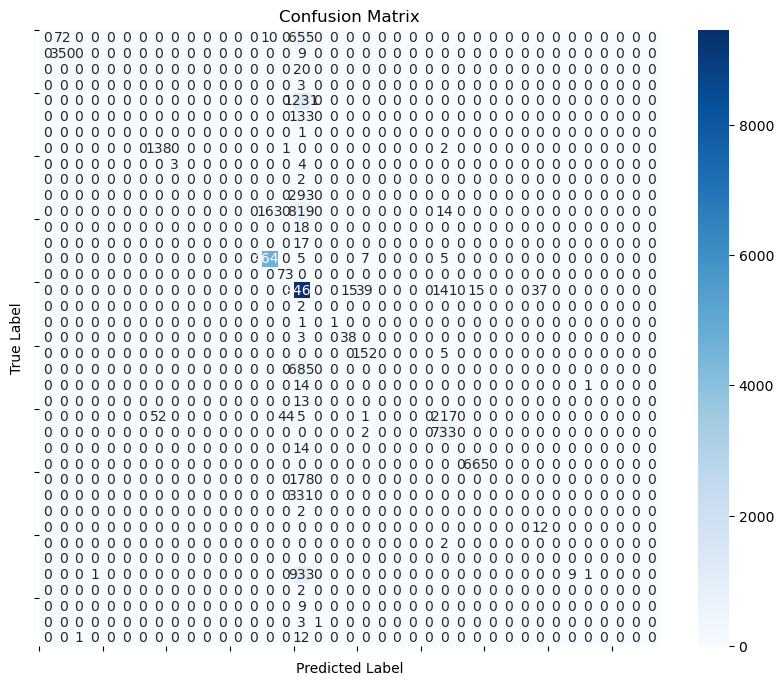

In [16]:
# Visualize the confusion matrix with improved labeling and annotations
import matplotlib.ticker as ticker

plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=rf_classifier.classes_, yticklabels=rf_classifier.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.show()


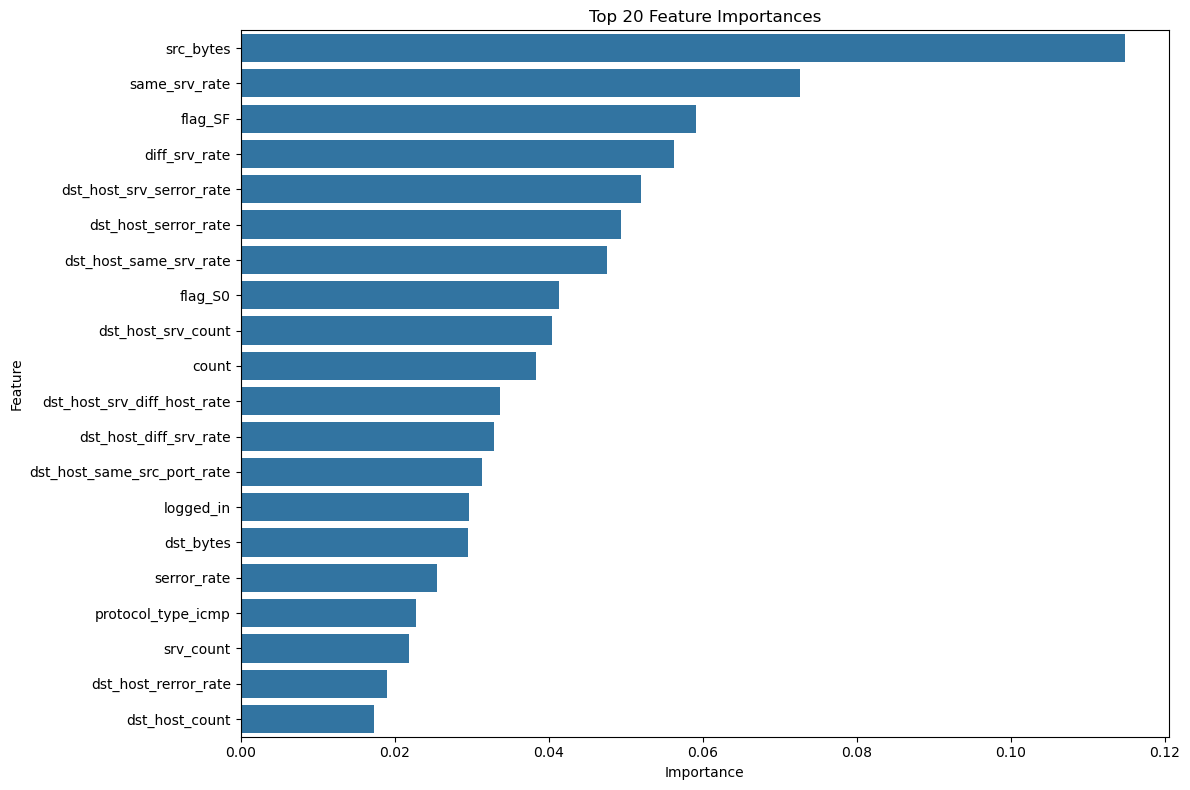

In [18]:
# Calculate and visualize feature importances
importances = rf_classifier.feature_importances_
features = X_train_encoded.columns

# Create a DataFrame for easy plotting
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot the top 20 most important features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
plt.title("Top 20 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


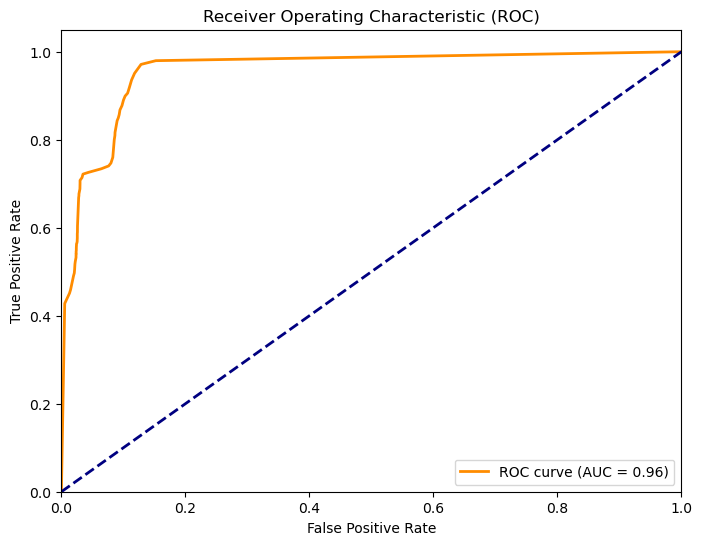

In [20]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# For binary classification, we can binarize the labels
# Here, we assume that 'normal' is one class and all other types are attacks.
y_test_binary = np.where(y_test == 'normal', 0, 1)
y_pred_proba = rf_classifier.predict_proba(X_test_encoded)  # Get probabilities for each class

# Since RandomForestClassifier in multi-class mode returns probabilities for each class,
# choose the probability for the positive class (attack). 
# Identify the column index for 'normal' and assume the other probabilities sum to attack.
# For simplicity, compute probability of attack as 1 - probability of 'normal'.
if 'normal' in rf_classifier.classes_:
    normal_index = list(rf_classifier.classes_).index('normal')
    attack_proba = 1 - y_pred_proba[:, normal_index]
else:
    attack_proba = y_pred_proba.max(axis=1)  # Fallback in case 'normal' is not found

# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test_binary, attack_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()
